In [1080]:
# MODELO HIDROLÓGICO TETIS AGREGADO - QUEBRADA EL CEMENTERIO
# Basado en Vélez et al. (2013) - Universidad Nacional de Colombia
# "Estrategia de simulación hidrológica distribuida: integración conceptual 
# de hidrología, hidráulica y geomorfología"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1081]:
# =============================================================================
# FUNCIÓN NASH-SUTCLIFFE EFFICIENCY
# =============================================================================

def nash_sutcliffe_efficiency(observed, simulated):
    """
    Calcula el coeficiente de eficiencia Nash-Sutcliffe.
    
    NSE = 1 - [Σ(Qo - Qs)²] / [Σ(Qo - Qo_mean)²]
    
    Interpretación:
    - NSE = 1.0: Ajuste perfecto
    - NSE = 0.0: El modelo es tan bueno como la media de observaciones
    - NSE < 0.0: El modelo es peor que usar la media
    
    Parameters:
    -----------
    observed : array
        Caudales observados [m³/s]
    simulated : array  
        Caudales simulados [m³/s]
        
    Returns:
    --------
    nse : float
        Coeficiente NSE (-∞ a 1, donde 1 es perfecto)
    """
    # Convertir a arrays numpy
    observed = np.array(observed)
    simulated = np.array(simulated)
    
    # Filtrar valores válidos (no NaN, no infinitos)
    valid_idx = ~(np.isnan(observed) | np.isnan(simulated) | 
                  np.isinf(observed) | np.isinf(simulated))
    
    obs = observed[valid_idx]
    sim = simulated[valid_idx]
    
    if len(obs) == 0:
        print("⚠️ No hay datos válidos para calcular NSE")
        return -999
    
    # Calcular NSE
    numerator = np.sum((obs - sim) ** 2)
    denominator = np.sum((obs - np.mean(obs)) ** 2)
    
    if denominator == 0:
        print("⚠️ Varianza de observaciones es cero")
        return -999
        
    nse = 1 - (numerator / denominator)
    return nse

# =============================================================================
# FUNCIÓN DIFFERENTIAL EVOLUTION (OPTIMIZACIÓN)
# =============================================================================

def differential_evolution(func, bounds, args=(), maxiter=200, popsize=15, seed=None):
    """
    Implementación simple de Evolución Diferencial para calibración de parámetros.
    
    La Evolución Diferencial es un algoritmo de optimización global que funciona con:
    1. Población inicial aleatoria
    2. Mutación: crear individuos candidatos
    3. Cruce: combinar características 
    4. Selección: mantener mejores individuos
    
    Parameters:
    -----------
    func : callable
        Función objetivo a minimizar f(x, *args)
    bounds : list of tuples
        Lista de tuplas (min, max) para cada parámetro
        Ejemplo: [(0.1, 5.0), (1.0, 50.0), ...]
    args : tuple
        Argumentos adicionales para la función objetivo
    maxiter : int
        Número máximo de iteraciones (generaciones)
    popsize : int
        Tamaño de la población
    seed : int or None
        Semilla para reproducibilidad
        
    Returns:
    --------
    result : object
        Resultado con atributos:
        - x : array, mejores parámetros encontrados
        - fun : float, mejor valor de función objetivo
        - success : bool, si la optimización fue exitosa
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Número de parámetros a optimizar
    n_params = len(bounds)
    print(f"Optimizando {n_params} parámetros con DE")
    print(f"Población: {popsize}, Generaciones: {maxiter}")
    
    # Crear población inicial aleatoria
    population = np.zeros((popsize, n_params))
    for i in range(n_params):
        low, high = bounds[i]
        population[:, i] = np.random.uniform(low, high, popsize)
    
    # Evaluar función objetivo para población inicial
    print("Evaluando población inicial...")
    fitness = np.zeros(popsize)
    for i in range(popsize):
        try:
            fitness[i] = func(population[i], *args)
        except:
            fitness[i] = 1e10  # Valor muy alto si hay error
    
    # Encontrar mejor individuo inicial
    best_idx = np.argmin(fitness)
    best_params = population[best_idx].copy()
    best_fitness = fitness[best_idx]
    
    print(f"Generación 0: Mejor valor = {best_fitness:.4f}")
    
    # Parámetros del algoritmo DE
    F = np.random.uniform(0.5, 1.0)   # Factor de escala para mutación (0.5-2.0)
    CR = 0.7  # Probabilidad de cruce (0.0-1.0)
    
    # Evolución por generaciones
    for generation in range(maxiter):
        # Para cada individuo en la población
        for i in range(popsize):
            
            # === MUTACIÓN ===
            # Seleccionar tres individuos diferentes al actual
            candidates = [idx for idx in range(popsize) if idx != i]
            if len(candidates) >= 3:
                a, b, c = np.random.choice(candidates, 3, replace=False)
            else:
                # Si la población es muy pequeña, usar con reemplazo
                a, b, c = np.random.choice(candidates, 3, replace=True)
            
            # Crear vector mutante: V = Xa + F * (Xb - Xc)
            mutant = population[a] + F * (population[b] - population[c])
            
            # Asegurar que el mutante esté dentro de los límites
            for j in range(n_params):
                low, high = bounds[j]
                if mutant[j] < low:
                    mutant[j] = low + np.random.random() * (high - low) * 0.1
                elif mutant[j] > high:
                    mutant[j] = high - np.random.random() * (high - low) * 0.1
            
            # === CRUCE ===
            # Crear vector de prueba combinando target y mutante
            trial = population[i].copy()
            
            # Asegurar que al menos un parámetro venga del mutante
            random_param = np.random.randint(n_params)
            
            for j in range(n_params):
                if np.random.random() < CR or j == random_param:
                    trial[j] = mutant[j]
            
            # === SELECCIÓN ===
            # Evaluar el individuo de prueba
            try:
                trial_fitness = func(trial, *args)
            except:
                trial_fitness = 1e10
            
            # Si es mejor, reemplazar el individuo actual
            if trial_fitness < fitness[i]:
                population[i] = trial.copy()
                fitness[i] = trial_fitness
                
                # Actualizar mejor global si es necesario
                if trial_fitness < best_fitness:
                    best_params = trial.copy()
                    best_fitness = trial_fitness
        
        # Mostrar progreso cada 10 generaciones
        if (generation + 1) % 10 == 0:
            current_best = np.min(fitness)
            mean_fitness = np.mean(fitness)
            print(f"Gen {generation + 1:3d}: Mejor = {current_best:.4f}, Promedio = {mean_fitness:.4f}")
    
    print(f"\n✅ Optimización completada")
    print(f"Mejor valor encontrado: {best_fitness:.4f}")
    
    # Crear objeto resultado similar a scipy.optimize
    class OptimizeResult:
        def __init__(self, x, fun, success=True):
            self.x = x          # Mejores parámetros
            self.fun = fun      # Mejor valor función objetivo
            self.success = success
            self.message = "Optimization terminated successfully"
    
    return OptimizeResult(best_params, best_fitness, True)

# =============================================================================
# FUNCIONES AUXILIARES PARA MÉTRICAS ADICIONALES
# =============================================================================

def calculate_rmse(observed, simulated):
    """Calcula Root Mean Square Error"""
    valid_idx = ~(np.isnan(observed) | np.isnan(simulated))
    if np.sum(valid_idx) == 0:
        return np.nan
    return np.sqrt(np.mean((observed[valid_idx] - simulated[valid_idx]) ** 2))

def calculate_mae(observed, simulated):
    """Calcula Mean Absolute Error"""
    valid_idx = ~(np.isnan(observed) | np.isnan(simulated))
    if np.sum(valid_idx) == 0:
        return np.nan
    return np.mean(np.abs(observed[valid_idx] - simulated[valid_idx]))

def calculate_pbias(observed, simulated):
    """Calcula Percent Bias"""
    valid_idx = ~(np.isnan(observed) | np.isnan(simulated))
    if np.sum(valid_idx) == 0:
        return np.nan
    obs = observed[valid_idx]
    sim = simulated[valid_idx]
    return 100 * np.sum(sim - obs) / np.sum(obs)

def calculate_r2(observed, simulated):
    """Calcula coeficiente de determinación R²"""
    valid_idx = ~(np.isnan(observed) | np.isnan(simulated))
    if np.sum(valid_idx) < 2:
        return np.nan
    obs = observed[valid_idx]
    sim = simulated[valid_idx]
    correlation_matrix = np.corrcoef(obs, sim)
    return correlation_matrix[0, 1] ** 2

def calculate_kge(observed, simulated):
    """Calcula Kling-Gupta Efficiency"""
    valid_idx = ~(np.isnan(observed) | np.isnan(simulated))
    if np.sum(valid_idx) < 2:
        return np.nan
    
    obs = observed[valid_idx]
    sim = simulated[valid_idx]
    
    # Componentes del KGE
    r = np.corrcoef(obs, sim)[0, 1]  # Correlación
    alpha = np.std(sim) / np.std(obs)  # Ratio de desviaciones estándar
    beta = np.mean(sim) / np.mean(obs)  # Ratio de medias
    
    # KGE
    kge = 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    return kge

# # =============================================================================
# # EJEMPLO DE USO
# # =============================================================================

# if __name__ == "__main__":
#     # Ejemplo de uso de NSE
#     qobs = np.array([1.0, 2.0, 3.0, 2.5, 1.5, 0.8, 1.2])
#     qsim = np.array([1.1, 1.9, 2.8, 2.3, 1.6, 0.9, 1.1])
    
#     nse = nash_sutcliffe_efficiency(qobs, qsim)
#     print(f"NSE ejemplo: {nse:.3f}")
    
#     # Ejemplo de función objetivo simple para DE
#     def objective_function(params):
#         """Función cuadrática simple: minimizar (x-2)² + (y-3)²"""
#         x, y = params
#         return (x - 2.0)**2 + (y - 3.0)**2
    
#     # Optimización con DE
#     bounds = [(0, 5), (0, 6)]  # x entre 0-5, y entre 0-6
#     result = differential_evolution_simple(objective_function, bounds, maxiter=50)
    
#     print(f"Parámetros óptimos: x={result.x[0]:.3f}, y={result.x[1]:.3f}")
#     print(f"Valor mínimo: {result.fun:.6f}")
#     print("(Debería ser aproximadamente x=2, y=3, valor=0)")

In [1082]:

# =============================================================================
# BLOQUE 1: CARGA Y PREPROCESAMIENTO DE DATOS
# =============================================================================

def load_and_preprocess_data(csv_path):
    """
    Carga y preprocesa los datos hidrometeorológicos desde archivo CSV.
    
    Según Vélez et al. (2013), los datos de entrada para TETIS incluyen:
    - Precipitación (P)  
    - Evapotranspiración potencial (PET)
    - Caudal observado (para calibración)
    
    Parameters:
    -----------
    csv_path : str
        Ruta del archivo CSV con los datos
        
    Returns:
    --------
    df : DataFrame
        DataFrame con las columnas procesadas
    """
    try:
        # Cargar CSV
        df = pd.read_csv(csv_path)
        print(f"Archivo cargado exitosamente: {csv_path}")
        print(f"Columnas encontradas: {list(df.columns)}")
        
        # Procesar fecha
        df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d')
        
        # Verificar y limpiar datos faltantes
        df['P_mm'] = df['P_mm'].fillna(0.0)
        df['PET_mm'] = df['PET_mm'].fillna(df['PET_mm'].mean())
        df['Qobs_m3s'] = df['Qobs_m3s'].fillna(df['Qobs_m3s'].mean())
        
        # Estadísticas básicas
        print(f"\n=== RESUMEN DE DATOS CARGADOS ===")
        print(f"Número de registros: {len(df)}")
        print(f"Período: {df['date'].min().strftime('%Y-%m-%d')} a {df['date'].max().strftime('%Y-%m-%d')}")
        print(f"Duración: {(df['date'].max() - df['date'].min()).days} días")
        
        print(f"\n=== ESTADÍSTICAS HIDROMETEOROLÓGICAS ===")
        print(f"Precipitación:")
        print(f"  - Media: {df['P_mm'].mean():.2f} mm/día")
        print(f"  - Máxima: {df['P_mm'].max():.2f} mm/día")
        print(f"  - Desviación estándar: {df['P_mm'].std():.2f} mm/día")
        print(f"  - Días con lluvia: {(df['P_mm'] > 0).sum()} ({(df['P_mm'] > 0).sum()/len(df)*100:.1f}%)")
        
        print(f"\nEvapotranspiración potencial:")
        print(f"  - Media: {df['PET_mm'].mean():.2f} mm/día")
        print(f"  - Máxima: {df['PET_mm'].max():.2f} mm/día")
        print(f"  - Mínima: {df['PET_mm'].min():.2f} mm/día")
        
        print(f"\nCaudal observado:")
        print(f"  - Media: {df['Qobs_m3s'].mean():.3f} m³/s")
        print(f"  - Máximo: {df['Qobs_m3s'].max():.3f} m³/s")
        print(f"  - Mínimo: {df['Qobs_m3s'].min():.3f} m³/s")
        
        # Detectar valores anómalos
        print(f"\n=== VERIFICACIÓN DE CALIDAD ===")
        print(f"Datos faltantes:")
        print(f"  - P_mm: {df['P_mm'].isna().sum()}")
        print(f"  - PET_mm: {df['PET_mm'].isna().sum()}")
        print(f"  - Qobs_m3s: {df['Qobs_m3s'].isna().sum()}")
        
        # Valores negativos (anómalos)
        neg_p = (df['P_mm'] < 0).sum()
        neg_pet = (df['PET_mm'] < 0).sum()
        neg_q = (df['Qobs_m3s'] < 0).sum()
        
        if neg_p > 0 or neg_pet > 0 or neg_q > 0:
            print(f"⚠️ ADVERTENCIA - Valores negativos encontrados:")
            if neg_p > 0: print(f"  - P_mm: {neg_p} valores")
            if neg_pet > 0: print(f"  - PET_mm: {neg_pet} valores")
            if neg_q > 0: print(f"  - Qobs_m3s: {neg_q} valores")
        
        return df
        
    except FileNotFoundError:
        print(f"❌ Error: No se encontró el archivo {csv_path}")
        return None
    except Exception as e:
        print(f"❌ Error al cargar el archivo: {e}")
        return None


In [1083]:

# =============================================================================
# BLOQUE 2: CLASE DEL MODELO TETIS AGREGADO
# =============================================================================

class TetisAggregatedModel:
    """
    Modelo TETIS agregado basado en la conceptualización de Vélez et al. (2013).
    
    El modelo TETIS maneja 5 tanques de almacenamiento:
    1. Interceptación estática (I)
    2. Almacenamiento superficial (S1) 
    3. Humedad del suelo (S2)
    4. Almacenamiento gravitacional (S3)
    5. Almacenamiento acuífero (S4)
    6. Canal (S5)
    
    Parámetros del modelo:
    - I_max: Capacidad máxima de intercepción
    - S1_max: Capacidad máxima de almacenamiento superficial  
    - FC: Capacidad de campo del suelo
    - k1: Coeficiente de evapotranspiración
    - n: Exponente no lineal del flujo subsuperficial
    - k2: Coeficiente de percolación
    - k3: Coeficiente de flujo subsuperficial
    - k4: Coeficiente de flujo base
    - k5: Coeficiente de velocidad en canal
    - k_gw: Coeficiente de flujo gravitacional
    - k_inf: Coeficiente de infiltración

    """
    
    def __init__(self, area):
        """
        Inicializa el modelo TETIS.
        
        Parameters:
        -----------
        area : float
            Área de la cuenca en m²
        """
        self.area = area  # Área de la cuenca en m²
        
        # # Rangos de parámetros según literatura TETIS
        self.param_bounds = [
            (0.1, 5.0),    # I_max [mm]
            (1.0, 50.0),   # S1_max [mm] 
            (50.0, 500.0), # FC [mm]
            (0.1, 1.0),    # k1 [adimensional]
            (1.0, 10.0),   # n [adimensional]
            (0.01, 1.0),   # k2 [día⁻¹]
            (0.01, 1.0),   # k3 [día⁻¹]
            (0.001, 0.1),  # k4 [día⁻¹]
            (0.1, 10.0),    # k5 [día⁻¹]
            (0.01, 1.0),    # k_gw (NUEVO)
            (0.05, 1.5)     # k_inf [d^-1]  <<< NUEVO (Antioquia: 0.1–1.0 d^-1 suele ir bien)
        ]


    def run(self, precip, etp, params, warmup_period=30):
        """
        Ejecuta la simulación del modelo TETIS.
        
        Parameters:
        -----------
        precip : array
            Serie de precipitación [mm/día]
        etp : array  
            Serie de evapotranspiración potencial [mm/día]
        params : array
            Parámetros del modelo [I_max, S1_max, FC, k1, n, k2, k3, k4, k5, k_gw, k_inf]
        warmup_period : int
            Período de calentamiento en días
            
        Returns:
        --------
        discharge : array
            Caudal simulado [m³/s]
        """
        n_days = len(precip)
        
        # Desempaquetar parámetros
        I_max, S1_max, FC, k1, n, k2, k3, k4, k5, k_gw, k_inf = params
        
        # Inicializar almacenamientos
        I = 0.0      # Intercepción [mm]
        S1 = 0.0     # Almacenamiento superficial [mm]
        S2 = FC * 0.5  # Humedad inicial del suelo (50% FC) [mm]
        S3 = 0.0     # Almacenamiento gravitacional [mm] 
        S4 = 10.0    # Almacenamiento acuífero inicial [mm]
        S5 = 0.0     # Almacenamiento en canal [mm]
        
        # Arrays para almacenar resultados
        discharge = np.zeros(n_days)
        
        for t in range(n_days):
            P = precip[t]
            PET = etp[t]
            
            # # 1. INTERCEPCIÓN
            # # La lluvia primero llena la intercepción
            # if P > 0:
            #     P_net = max(0, P + I - I_max)
            #     I = min(I_max, I + P)
            # else:
            #     P_net = 0

            # # Evaporación desde intercepción
            # E_I = min(I, PET)
            # I = max(0, I - E_I)
            # PET_remaining = max(0, PET - E_I)
            
            # 1. INTERCEPCIÓN (I) y throughfall
            # capacidad remanente del dosel
            cap_rem = max(0.0, I_max - I)
            # lluvia que cae al dosel hasta llenar
            retained = min(P, cap_rem)
            I = I + retained
            # throughfall (P neta)
            P_net = max(0.0, P - retained)  # Asegura no negativo

            # evaporación desde intercepción
            E_I = min(I, PET)
            I = max(0.0, I - E_I)
            PET_remaining = max(0.0, PET - E_I)


            
            # # 2. ALMACENAMIENTO SUPERFICIAL (S1)
            # # Entrada al almacenamiento superficial
            # S1 += P_net

            # # Evaporación desde S1
            # E_S1 = min(S1, PET_remaining * 0.1)  # Factor reducido para S1
            # S1 = max(0, S1 - E_S1)
            # PET_remaining = max(0, PET_remaining - E_S1)
            
            # # Exceso que pasa al suelo
            # if S1 > S1_max:
            #     excess_to_soil = S1 - S1_max
            #     S1 = S1_max
            # else:
            #     excess_to_soil = S1 * 0.1  # Infiltración gradual
            #     S1 = S1 * 0.9

            # 2. ALMACENAMIENTO SUPERFICIAL (S1)
            S1 += P_net

            # Evaporación limitada desde S1 (pequeña fracción)
            E_S1 = min(S1, 0.1 * PET_remaining)
            S1 = max(0.0, S1 - E_S1)
            PET_remaining = max(0.0, PET_remaining - E_S1)

            # # Infiltración desde S1 hacia S2 con tasa k_inf
            # # Flujo (mm/d) = k_inf * S1 * (1 + S1/S1_max)  (capado por S1)
            # infil = k_inf * S1 * (1.0 + S1 / (S1_max + 1e-6))
            # infil = min(infil, S1)
            # S1 -= infil
            # excess_to_soil = infil

            # # Exceso por capacidad superficial (escorrentía rápida a canal opcional)
            # if S1 > S1_max:
            #     overland = S1 - S1_max
            #     S1 = S1_max
            # else:
            #     overland = 0.0

            # # 3. HUMEDAD DEL SUELO (S2)
            # S2 += excess_to_soil

            # Infiltración desde S1 hacia S2 con tasa k_inf
            if S1 > S1_max:
                excess = S1 - S1_max
                S1 = S1_max
                infil = min(excess * 0.8, excess)  # 80% infiltra, resto overland (ajustable)
                overland = excess - infil
            else:
                infil = k_inf * S1  # Tasa lineal cuando no saturado
                overland = 0.0
                S1 = max(0.0, S1 - infil)
            
            # 3. HUMEDAD DEL SUELO (S2)
            S2 += infil

            # Evapotranspiración real desde el suelo
            if S2 > 0:
                ET_factor = min(1.0, S2 / (FC))  # Factor de estrés hídrico
                ETR = min(S2, PET_remaining * k1 * ET_factor)
                S2 = max(0.0, S2 - ETR)
            else:
                ETR = 0.0
            
            # Percolación hacia zona no saturada (S3)
            if S2 > FC:
                percolation = k2 * (S2 - FC)
                S2 = max(0.0, S2 - percolation)
            else:
                percolation = 0.0

            S2 = max(0, S2 - percolation)

            # # 4. ZONA NO SATURADA (S3)
            # S3 = S3 + percolation
            
            # # Flujo subsuperficial (interflow)
            # if S3 > 0:
            #     interflow = k3 * (S3 ** n)
            #     S3 = max(0, S3 - interflow)
            # else:
            #     interflow = 0
                
            # # Recarga al acuífero
            # groundwater_recharge = k2 * 0.5 * S3
            # S3 = max(0, S3 - groundwater_recharge)
            
            # # 5. ACUÍFERO (S4)
            # S4 = S4 + groundwater_recharge
            
            # # Flujo base
            # baseflow = k4 * S4
            # S4 = max(0, S4 - baseflow)

            # 4. ZONA NO SATURADA (S3)
            S3 += percolation

            # Flujo subsuperficial (no lineal, adimensional en base)
            interflow = k3 * S3 * (S3 / (FC + 1e-6))**(n - 1.0)  # mantiene unidades de k3 como d^-1
            interflow = min(interflow, S3)
            S3 = max(0.0, S3 - interflow)

            # Recarga al acuífero separada
            groundwater_recharge = k_gw * S3
            groundwater_recharge = min(groundwater_recharge, S3)
            S3 = max(0.0, S3 - groundwater_recharge)

            # 5. ACUÍFERO (S4)
            S4 += groundwater_recharge
            baseflow = k4 * S4
            baseflow = min(baseflow, S4)
            S4 = max(0.0, S4 - baseflow)
            
            # 6. CANAL (S5)
            # Entrada al canal: interflow + baseflow + escorrentía superficial
            channel_inflow = interflow + baseflow + overland
            S5 += channel_inflow

            # Flujo de salida del canal
            channel_outflow = k5 * S5 
            # S5 = max(0, S5 - channel_outflow)
            channel_outflow = min(channel_outflow, S5)
            S5 = max(0.0, S5 - channel_outflow)
            
            # Conversión a caudal [m³/s]
            # channel_outflow está en mm/día, convertir a m³/s
            discharge[t] = (channel_outflow / 1000.0) * self.area / 86400.0
        
        return discharge
    
    def objective_function(self, params, precip, etp, qobs):
        """
        Función objetivo para la calibración (minimizar RMSE).
        """
        try:
            qsim = self.run(precip, etp, params)
            
            # Filtrar valores válidos
            valid_idx = ~(np.isnan(qobs) | np.isnan(qsim) | np.isinf(qobs) | np.isinf(qsim))

            if np.sum(valid_idx) == 0:
                return 1e6  # Valor alto si no hay datos válidos
                
            qobs_valid = qobs[valid_idx]
            qsim_valid = qsim[valid_idx]
            
            # Calcular RMSE
            rmse = np.sqrt(np.mean((qobs_valid - qsim_valid) ** 2))
            
            return rmse
        except:
            return 1e6  # Valor alto si hay error

    def calibrate(self, precip, etp, qobs, maxiter=200, popsize=15):
        """
        Calibra el modelo usando evolución diferencial.
        
        Parameters:
        -----------
        precip : array
            Precipitación [mm/día]
        etp : array
            Evapotranspiración potencial [mm/día] 
        qobs : array
            Caudal observado [m³/s]
        maxiter : int
            Máximo número de iteraciones
        popsize : int
            Tamaño de la población
            
        Returns:
        --------
        best_params : array
            Mejores parámetros encontrados
        """
        print("Iniciando calibración del modelo TETIS...")
        
        result = differential_evolution(
            self.objective_function,
            self.param_bounds,
            args=(precip, etp, qobs),
            maxiter=maxiter,
            popsize=popsize,
            seed=42
        )
        
        final_rmse = result.fun
        print(f"\n✅ Calibración completada")
        print(f"RMSE final: {final_rmse:.4f} m³/s")
        
        # Calcular métricas adicionales con los mejores parámetros
        qsim_best = self.run(precip, etp, result.x)
        
        # Filtrar valores válidos
        valid_idx = ~(np.isnan(qobs) | np.isnan(qsim_best))
        qobs_valid = qobs[valid_idx]
        qsim_valid = qsim_best[valid_idx]
        
        if len(qobs_valid) > 0:
            # RMSE (ya calculado)
            rmse = final_rmse
            # NSE
            nse = nash_sutcliffe_efficiency(qobs_valid, qsim_valid)
            # R²
            r2 = np.corrcoef(qobs_valid, qsim_valid)[0, 1] ** 2 if len(qobs_valid) > 1 else 0
            # PBIAS
            pbias = 100 * np.sum(qsim_valid - qobs_valid) / np.sum(qobs_valid)
            
        # MAE
        mae = np.mean(np.abs(qobs_valid - qsim_valid))
        
        print(f"\nMétricas de calibración:")
        print(f"RMSE: {rmse:.4f} m³/s")
        print(f"NSE:  {nse:.4f}")
        print(f"R²:   {r2:.4f}")
        print(f"MAE:  {mae:.4f} m³/s")
        print(f"PBIAS: {pbias:.2f}%")

        # Mostrar parámetros calibrados
        param_names = ['I_max', 'S1_max', 'FC', 'k1', 'n', 'k2', 'k3', 'k4', 'k5', 'k_gw', 'k_inf']
        print(f"\nParámetros calibrados:")
        print("-" * 30)
        for name, param in zip(param_names, result.x):
            print(f"{name:8s}: {param:.4f}")
        
        return result.x


In [1084]:

# =============================================================================
# BLOQUE 3: FUNCIONES DE EVALUACIÓN Y MÉTRICAS
# =============================================================================

def evaluate_model(qobs, qsim):
    """
    Evalúa el desempeño del modelo usando múltiples métricas.
    
    Métricas implementadas según estándares internacionales:
    - NSE: Nash-Sutcliffe Efficiency
    - RMSE: Root Mean Square Error  
    - MAE: Mean Absolute Error
    - PBIAS: Percent Bias
    - R²: Coeficiente de determinación
    """
    # Filtrar valores válidos
    valid_idx = ~(np.isnan(qobs) | np.isnan(qsim))
    qobs_valid = qobs[valid_idx]
    qsim_valid = qsim[valid_idx]
    
    if len(qobs_valid) == 0:
        return {"Error": "No hay datos válidos para evaluación"}
    
    # NSE - Nash-Sutcliffe Efficiency
    nse = nash_sutcliffe_efficiency(qobs_valid, qsim_valid)
    
    # RMSE - Root Mean Square Error
    rmse = np.sqrt(np.mean((qobs_valid - qsim_valid) ** 2))
    
    # MAE - Mean Absolute Error
    mae = np.mean(np.abs(qobs_valid - qsim_valid))
    
    # PBIAS - Percent Bias
    pbias = 100 * np.sum(qsim_valid - qobs_valid) / np.sum(qobs_valid)
    
    # R² - Coeficiente de determinación
    r2 = np.corrcoef(qobs_valid, qsim_valid)[0, 1] ** 2
    
    # KGE - Kling-Gupta Efficiency
    r = np.corrcoef(qobs_valid, qsim_valid)[0, 1]
    alpha = np.std(qsim_valid) / np.std(qobs_valid)
    beta = np.mean(qsim_valid) / np.mean(qobs_valid)
    kge = 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    
    return {
        "NSE": nse,
        "RMSE": rmse,
        "MAE": mae, 
        "PBIAS": pbias,
        "R²": r2,
        "KGE": kge,
        "n_datos": len(qobs_valid)
    }


In [ ]:

# =============================================================================
# BLOQUE 4: FUNCIONES DE VISUALIZACIÓN
# =============================================================================

def plot_results(dates, qobs, qsim, precip, etp):
    """
    Genera gráficos de resultados del modelo.
    """
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    
    # Gráfico 1: Precipitación y PET
    axes[0].plot(dates, precip, alpha=0.7, label='Precipitación', color='blue', linewidth=1)
    axes[0].plot(dates, etp, color='red', linewidth=1, label='PET')
    axes[0].set_ylabel('Lámina [mm/día]')
    axes[0].set_title('Forzamiento Meteorológico - Quebrada El Cementerio')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].invert_yaxis()  # Precipitación hacia abajo
    
    # Gráfico 2: Caudales observado vs simulado
    axes[1].plot(dates, qobs, 'b-', label='Observado', linewidth=1.5)
    axes[1].plot(dates, qsim, 'r--', label='Simulado', linewidth=1.5)
    axes[1].set_ylabel('Caudal [m³/s]')
    axes[1].set_title('Hidrograma - Caudal Observado vs Simulado')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Gráfico 3: Dispersión
    axes[2].scatter(qobs, qsim, alpha=0.6, s=20)
    axes[2].plot([min(qobs), max(qobs)], [min(qobs), max(qobs)], 'k--', label='1:1')
    axes[2].set_xlabel('Caudal Observado [m³/s]')
    axes[2].set_ylabel('Caudal Simulado [m³/s]')
    axes[2].set_title('Dispersión: Observado vs Simulado')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_qq_plot(qobs, qsim, title):
    """
    Genera un gráfico Q-Q para comparar distribuciones.
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Ordenar los datos
    qobs_sorted = np.sort(qobs)
    qsim_sorted = np.sort(qsim)
    
    # Crear cuantiles
    n = len(qobs_sorted)
    quantiles = np.linspace(0, 1, n)
    
    ax.scatter(qobs_sorted, qsim_sorted, alpha=0.6, s=20)
    ax.plot([min(qobs_sorted), max(qobs_sorted)], 
            [min(qobs_sorted), max(qobs_sorted)], 'r--', label='1:1')
    
    ax.set_xlabel('Caudal Observado [m³/s]')
    ax.set_ylabel('Caudal Simulado [m³/s]')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.show()

    


In [1086]:

# =============================================================================
# BLOQUE 5: ANÁLISIS DE SENSIBILIDAD DE PARÁMETROS
# =============================================================================

def parameter_sensitivity_analysis(model, precip, etp, qobs, base_params):
    """
    Análisis de sensibilidad de parámetros del modelo TETIS.
    """
    param_names = ['I_max', 'S1_max', 'FC', 'k1', 'n', 'k2', 'k3', 'k4', 'k5', 'k_gw', 'k_inf']
    sensitivity = {}
    
    base_nse = -model.objective_function(base_params, precip, etp, qobs)
    
    for i, param_name in enumerate(param_names):
        # Variación del parámetro ±20%
        sensitivity[param_name] = {}
        
        # Incremento 20%
        params_up = base_params.copy()
        params_up[i] *= 1.2
        nse_up = -model.objective_function(params_up, precip, etp, qobs)
        
        # Decremento 20%
        params_down = base_params.copy() 
        params_down[i] *= 0.8
        nse_down = -model.objective_function(params_down, precip, etp, qobs)
        
        # Sensibilidad relativa
        sensitivity[param_name]['base_nse'] = base_nse
        sensitivity[param_name]['nse_up'] = nse_up
        sensitivity[param_name]['nse_down'] = nse_down
        sensitivity[param_name]['sensitivity'] = (nse_up - nse_down) / (2 * 0.2 * base_nse)
        
    return sensitivity


In [1087]:

# =============================================================================
# BLOQUE EJEMPLO DE USO
# =============================================================================

# Ejemplo de uso del modelo para la Quebrada El Cementerio:

# Definir la ruta del archivo
csv_path = r"D:\OneDrive - Grupo EPM\Documentos\Python Scripts\Codigos_GITHUB\ModHD\data\Datos_prueba_2.csv"

# Cargar los datos
df = load_and_preprocess_data(csv_path)
area_cuenca = 101e6  # Área de la cuenca en m² (101 km²)

# Balance aproximado (mm/año)
years = (df['date'].max() - df['date'].min()).days / 365
total_p = df['P_mm'].sum() / years
total_etp = df['PET_mm'].sum() / years
total_q_mm = (df['Qobs_m3s'] * 86400 / area_cuenca * 1000).sum() / years  # Convert Q a mm
print(f"\nBalance anual: P={total_p:.1f} mm, ETP={total_etp:.1f} mm, Q={total_q_mm:.1f} mm")
if abs(total_p - total_etp - total_q_mm) / total_p > 0.1:
    print("⚠️ Imbalance >10%: Revisar datos, Balances: En cuencas cerradas, P ≈ ET + Q + ΔS (largo plazo ΔS~0)")


Archivo cargado exitosamente: D:\OneDrive - Grupo EPM\Documentos\Python Scripts\Codigos_GITHUB\ModHD\data\Datos_prueba_2.csv
Columnas encontradas: ['date', 'Afluente_SN', 'a', 'b', 'Temp_C', 'Qobs_m3s', 'P_mm', 'PET_mm']

=== RESUMEN DE DATOS CARGADOS ===
Número de registros: 24837
Período: 1950-01-01 a 2017-12-31
Duración: 24836 días

=== ESTADÍSTICAS HIDROMETEOROLÓGICAS ===
Precipitación:
  - Media: 5.68 mm/día
  - Máxima: 86.00 mm/día
  - Desviación estándar: 9.52 mm/día
  - Días con lluvia: 14415 (58.0%)

Evapotranspiración potencial:
  - Media: 3.25 mm/día
  - Máxima: 3.25 mm/día
  - Mínima: 3.25 mm/día

Caudal observado:
  - Media: 2.001 m³/s
  - Máximo: 45.879 m³/s
  - Mínimo: 0.080 m³/s

=== VERIFICACIÓN DE CALIDAD ===
Datos faltantes:
  - P_mm: 0
  - PET_mm: 0
  - Qobs_m3s: 0

Balance anual: P=2073.1 mm, ETP=1187.0 mm, Q=624.8 mm
⚠️ Imbalance >10%: Revisar datos, Balances: En cuencas cerradas, P ≈ ET + Q + ΔS (largo plazo ΔS~0)


In [1088]:
# Ver las columnas disponibles
print("Columnas en el DataFrame:")
print(df.columns.tolist())

# Ver tipos de datos
print("\nTipos de datos:")
print(df.dtypes)

# Estadísticas básicas
print("\nEstadísticas descriptivas:")
print(df[['P_mm', 'PET_mm', 'Qobs_m3s']].describe())

Columnas en el DataFrame:
['date', 'Afluente_SN', 'a', 'b', 'Temp_C', 'Qobs_m3s', 'P_mm', 'PET_mm']

Tipos de datos:
date           datetime64[ns]
Afluente_SN           float64
a                     float64
b                     float64
Temp_C                float64
Qobs_m3s              float64
P_mm                  float64
PET_mm                float64
dtype: object

Estadísticas descriptivas:
               P_mm        PET_mm      Qobs_m3s
count  24837.000000  2.483700e+04  24837.000000
mean       5.679501  3.252000e+00      2.001071
std        9.518919  8.881963e-16      2.950008
min        0.000000  3.252000e+00      0.080000
25%        0.000000  3.252000e+00      0.818000
50%        1.016000  3.252000e+00      1.151000
75%        7.600000  3.252000e+00      1.569000
max       86.000000  3.252000e+00     45.879000


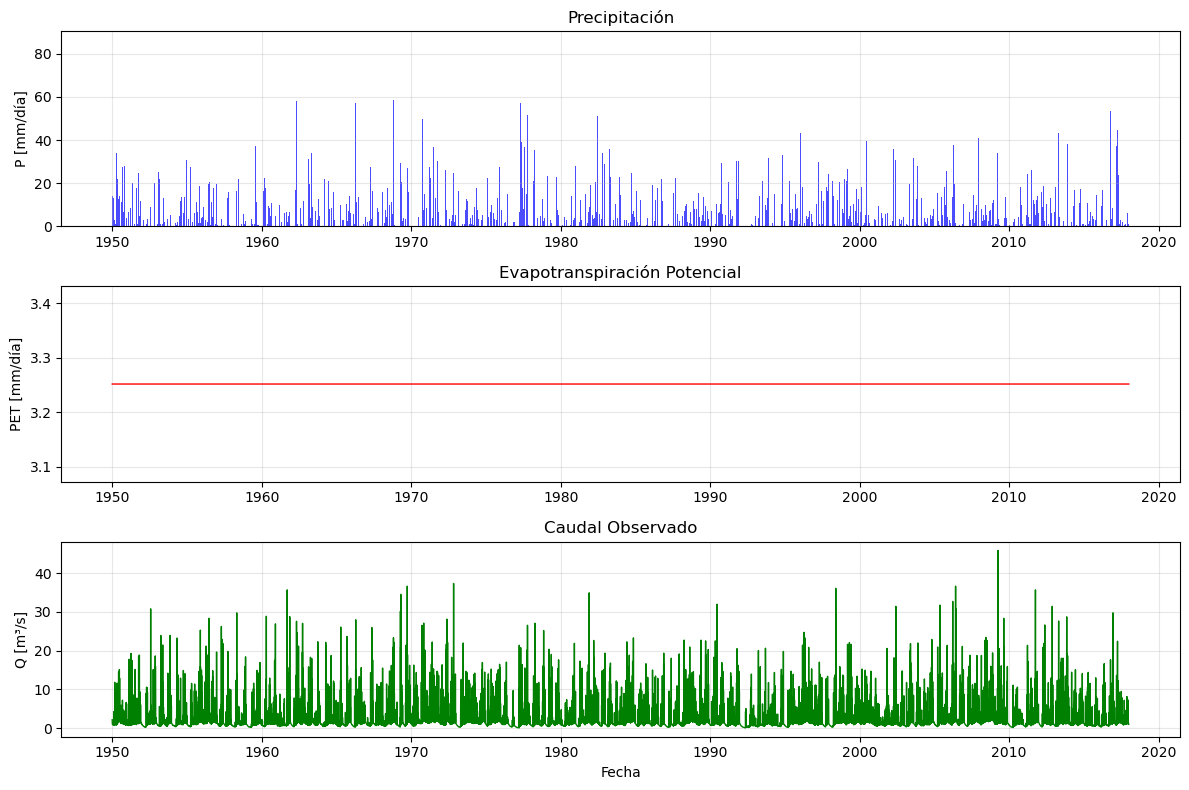

In [1089]:
# Gráfico rápido para verificar los datos
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Precipitación
axes[0].bar(df['date'], df['P_mm'], alpha=0.7, color='blue', width=1)
axes[0].set_ylabel('P [mm/día]')
axes[0].set_title('Precipitación')
axes[0].grid(True, alpha=0.3)

# PET
axes[1].plot(df['date'], df['PET_mm'], 'r-', linewidth=1)
axes[1].set_ylabel('PET [mm/día]')
axes[1].set_title('Evapotranspiración Potencial')
axes[1].grid(True, alpha=0.3)

# Caudal
axes[2].plot(df['date'], df['Qobs_m3s'], 'g-', linewidth=1)
axes[2].set_ylabel('Q [m³/s]')
axes[2].set_title('Caudal Observado')
axes[2].set_xlabel('Fecha')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [1090]:

# 2. Dividir en entrenamiento y validación
split_idx = int(len(df) * 0.7)
train_df = df.iloc[:split_idx]
val_df = df.iloc[split_idx:]


In [1091]:

# 3. Crear modelo

# Crear el modelo
model = TetisAggregatedModel(area=area_cuenca)

print("✅ Modelo TETIS creado exitosamente")
print(f"Área de la cuenca: {area_cuenca/1000000:.1f} km²")


✅ Modelo TETIS creado exitosamente
Área de la cuenca: 101.0 km²


In [1092]:
# =============================================================================
# BLOQUE DE DIAGNÓSTICO DE UNIDADES Y ESCALA
# =============================================================================

print("=== DIAGNÓSTICO DE UNIDADES ===")
print(f"Área actual del modelo: {area_cuenca:,.0f} m² = {area_cuenca/1000000:.1f} km²")

# Calcular área estimada basada en caudales
# Usando la fórmula inversa del modelo para estimar área correcta
qobs_mean = df['Qobs_m3s'].mean()
precip_mean = df['P_mm'].mean()

# Estimación rugosa: Q ≈ (P - ET) * Area / conversion_factor
# Area ≈ Q * conversion_factor / (P - ET)
et_estimate = df['PET_mm'].mean() * 0.7  # Asumiendo 70% de PET como ET real
runoff_coeff = 0.3  # Coeficiente de escorrentía típico (30%)
effective_precip = precip_mean * runoff_coeff

if effective_precip > 0:
    estimated_area = qobs_mean * 86400 * 1000 / effective_precip  # m²
    print(f"Área estimada basada en balance hídrico: {estimated_area:,.0f} m² = {estimated_area/1000000:.2f} km²")
    
    # Factor de corrección
    correction_factor = estimated_area / area_cuenca
    print(f"Factor de corrección sugerido: {correction_factor:.4f}")
else:
    print("No se puede estimar área con precipitación efectiva = 0")

print(f"\nRatio caudales: Simulado/Observado = {np.mean(qsim_test)/qobs_mean:.1f}")

=== DIAGNÓSTICO DE UNIDADES ===
Área actual del modelo: 101,000,000 m² = 101.0 km²
Área estimada basada en balance hídrico: 101,471,647 m² = 101.47 km²
Factor de corrección sugerido: 1.0047

Ratio caudales: Simulado/Observado = 0.8


In [1093]:
# Ver los rangos de parámetros definidos
param_names = ['I_max', 'S1_max', 'FC', 'k1', 'n', 'k2', 'k3', 'k4', 'k5', 'k_gw', 'k_inf']
print("Rangos de parámetros del modelo TETIS:")
print("-" * 50)
for i, (name, bounds) in enumerate(zip(param_names, model.param_bounds)):
    print(f"{name:8s}: {bounds[0]:6.3f} - {bounds[1]:6.3f}")

Rangos de parámetros del modelo TETIS:
--------------------------------------------------
I_max   :  0.100 -  5.000
S1_max  :  1.000 - 50.000
FC      : 50.000 - 500.000
k1      :  0.100 -  1.000
n       :  1.000 - 10.000
k2      :  0.010 -  1.000
k3      :  0.010 -  1.000
k4      :  0.001 -  0.100
k5      :  0.100 - 10.000
k_gw    :  0.010 -  1.000
k_inf   :  0.050 -  1.500


In [1104]:
# Parámetros de prueba (valores primera calibracion)
test_params = [
    2.9343,  # I_max
    39.2682, # S1_max
    66.7894, # FC
    0.9828,  # k1
    1.8432,  # n
    0.5148,  # k2
    0.8991,  # k3
    0.0177,  # k4
    7.1611,  # k5
    0.5174,  # k_gw
    0.0604   # k_inf
]

print("Parámetros de prueba (valores medios):")
for name, param in zip(param_names, test_params):
    print(f"{name}: {param:.3f}")

# Ejecutar una simulación de prueba con los primeros 800 días
n_test = min(200, len(df))
precip_test = df['P_mm'].values[:n_test]
etp_test = df['PET_mm'].values[:n_test]

print(f"\nEjecutando simulación de prueba con {n_test} días...")
qsim_test = model.run(precip_test, etp_test, test_params)

print(f"✅ Simulación completada")
print(f"Caudal simulado - Min: {np.min(qsim_test):.3f} m³/s, Max: {np.max(qsim_test):.3f} m³/s, Promedio: {np.mean(qsim_test):.3f} m³/s")

Parámetros de prueba (valores medios):
I_max: 2.934
S1_max: 39.268
FC: 66.789
k1: 0.983
n: 1.843
k2: 0.515
k3: 0.899
k4: 0.018
k5: 7.161
k_gw: 0.517
k_inf: 0.060

Ejecutando simulación de prueba con 200 días...
✅ Simulación completada
Caudal simulado - Min: 0.073 m³/s, Max: 15.133 m³/s, Promedio: 1.892 m³/s


In [1105]:
# Ejemplo de uso del NSE
qobs = df['Qobs_m3s'].values[:200]  # Primeros 200 días
qsim = model.run(train_df['P_mm'].values[:200], train_df['PET_mm'].values[:200], test_params)

nse = nash_sutcliffe_efficiency(qobs, qsim)
print(f"NSE: {nse:.4f}")

NSE: 0.9220



RMSE con parámetros de prueba: 0.7504 m³/s


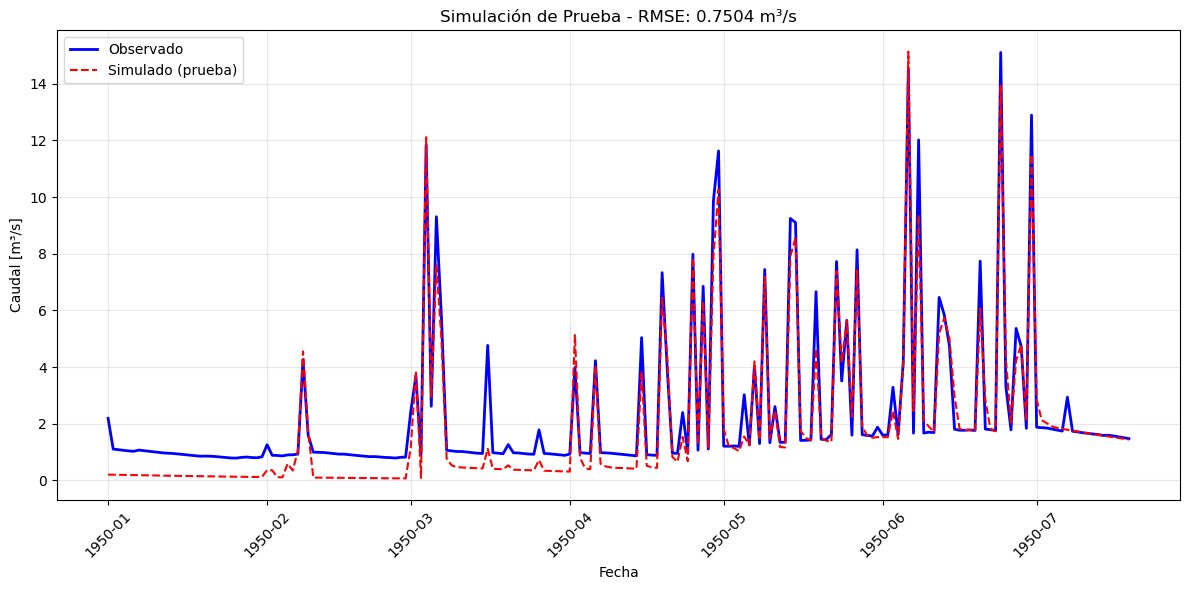

In [1106]:
# Comparar con el caudal observado
qobs_test = df['Qobs_m3s'].values[:n_test]

# Calcular RMSE de la prueba
valid_idx = ~(np.isnan(qobs_test) | np.isnan(qsim_test))
qobs_valid = qobs_test[valid_idx]
qsim_valid = qsim_test[valid_idx]

if len(qobs_valid) > 0:
    rmse_test = np.sqrt(np.mean((qobs_valid - qsim_valid) ** 2))
    print(f"\nRMSE con parámetros de prueba: {rmse_test:.4f} m³/s")
    
    # Gráfico rápido de comparación
    plt.figure(figsize=(12, 6))
    dates_test = df['date'].values[:n_test]
    plt.plot(dates_test, qobs_test, 'b-', label='Observado', linewidth=2)
    plt.plot(dates_test, qsim_test, 'r--', label='Simulado (prueba)', linewidth=1.5)
    plt.xlabel('Fecha')
    plt.ylabel('Caudal [m³/s]')
    plt.title(f'Simulación de Prueba - RMSE: {rmse_test:.4f} m³/s')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("❌ No hay datos válidos para comparación")

In [1097]:
# Probar la función objetivo directamente
rmse_objetivo = model.objective_function(test_params, precip_test, etp_test, qobs_test)
print(f"RMSE desde función objetivo: {rmse_objetivo:.4f} m³/s")

print(f"\n✅ Bloque 2 (Modelo) verificado correctamente")
print("El modelo está listo para la calibración")

RMSE desde función objetivo: 0.5970 m³/s

✅ Bloque 2 (Modelo) verificado correctamente
El modelo está listo para la calibración


In [1098]:

# 4. Calibrar
precip_train = train_df['P_mm'].values
etp_train = train_df['PET_mm'].values  
qobs_train = train_df['Qobs_m3s'].values
params = model.calibrate(precip_train, etp_train, qobs_train)


Iniciando calibración del modelo TETIS...
Optimizando 11 parámetros con DE
Población: 15, Generaciones: 200
Evaluando población inicial...
Generación 0: Mejor valor = 1.2656
Gen  10: Mejor = 0.8840, Promedio = 1.2252
Gen  20: Mejor = 0.8736, Promedio = 1.0407
Gen  30: Mejor = 0.8688, Promedio = 0.9792
Gen  40: Mejor = 0.8247, Promedio = 0.8890
Gen  50: Mejor = 0.7696, Promedio = 0.8309
Gen  60: Mejor = 0.7487, Promedio = 0.7951
Gen  70: Mejor = 0.7197, Promedio = 0.7637
Gen  80: Mejor = 0.7197, Promedio = 0.7576
Gen  90: Mejor = 0.7041, Promedio = 0.7375
Gen 100: Mejor = 0.6862, Promedio = 0.7140
Gen 110: Mejor = 0.6843, Promedio = 0.6992
Gen 120: Mejor = 0.6796, Promedio = 0.6929
Gen 130: Mejor = 0.6736, Promedio = 0.6870
Gen 140: Mejor = 0.6736, Promedio = 0.6859
Gen 150: Mejor = 0.6736, Promedio = 0.6834
Gen 160: Mejor = 0.6670, Promedio = 0.6787
Gen 170: Mejor = 0.6622, Promedio = 0.6737
Gen 180: Mejor = 0.6559, Promedio = 0.6677
Gen 190: Mejor = 0.6486, Promedio = 0.6601
Gen 200: 

In [1099]:

# 5. Validar
precip_val = val_df['P_mm'].values
etp_val = val_df['PET_mm'].values
qobs_val = val_df['Qobs_m3s'].values
qsim_val = model.run(precip_val, etp_val, params)


In [1100]:

# 6. Evaluar
metrics = evaluate_model(qobs_val, qsim_val)
print("Métricas de evaluación:")
for name, value in metrics.items():
    print(f"{name}: {value:.3f}")


Métricas de evaluación:
NSE: 0.953
RMSE: 0.667
MAE: 0.383
PBIAS: -4.487
R²: 0.955
KGE: 0.925
n_datos: 7452.000


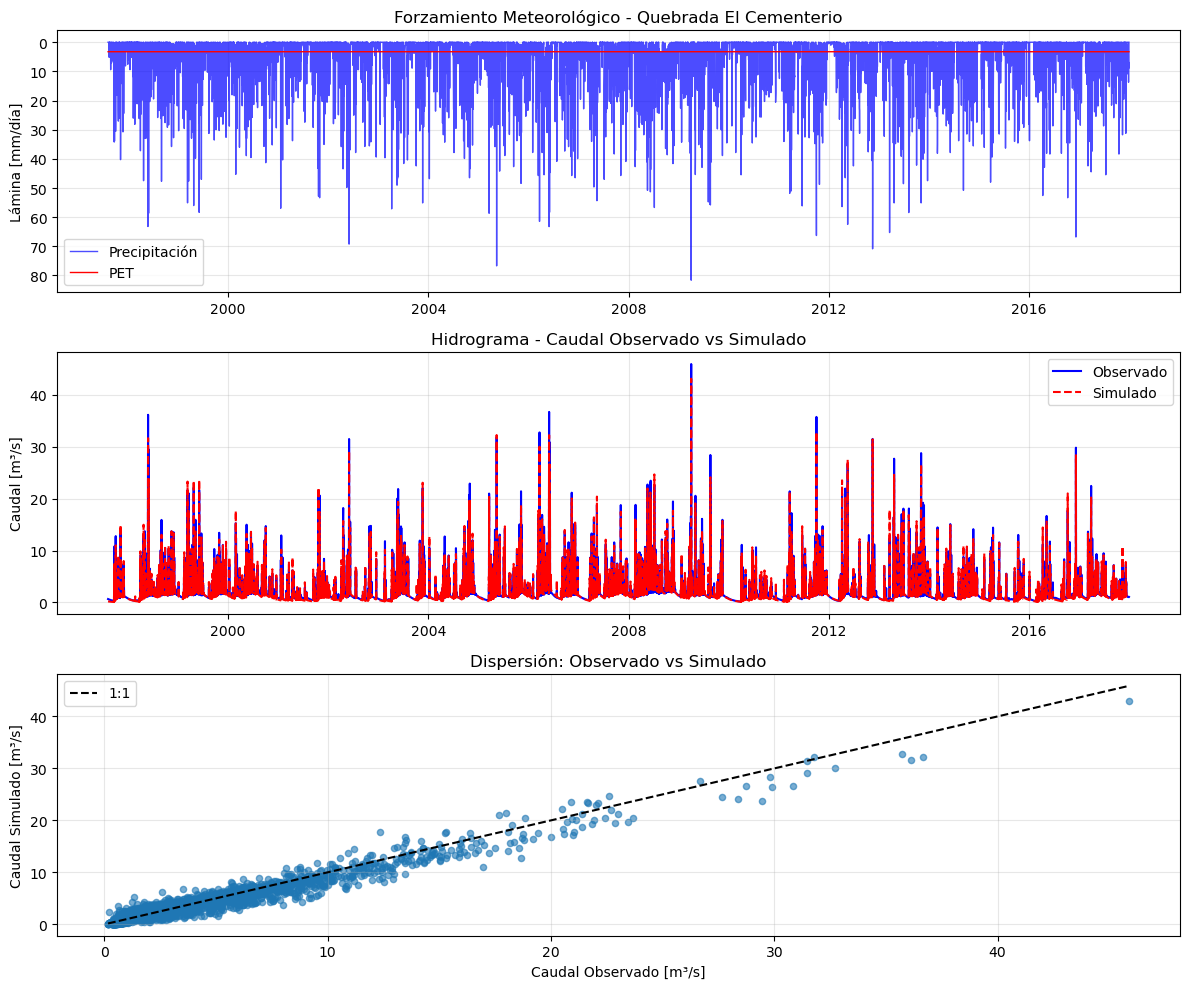

In [ ]:

# 7. Visualizar
plot_results(val_df['date'].values, qobs_val, qsim_val, precip_val, etp_val)


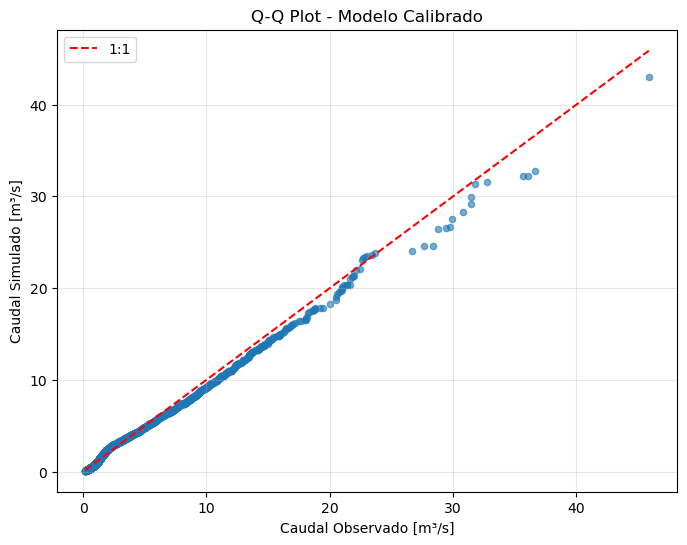

In [1107]:
plot_qq_plot(qobs_val, qsim_val, "Q-Q Plot - Modelo Calibrado")